In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dfident = pd.read_csv('train_identity.csv')
dftrans = pd.read_csv('train_transaction.csv')

# Data Preparation and Visualization

In [3]:
print(dfident.shape)
print(dftrans.shape)
df = pd.merge(dftrans, dfident, on='TransactionID', how='left')
print(df.shape)

(144233, 41)
(590540, 394)
(590540, 434)


In [4]:
print('Total number of transactions: {}\nNumber of fraudulent transactions: {}'.format(len(df), len(df[df['isFraud'] == 1])))

Total number of transactions: 590540
Number of fraudulent transactions: 20663


In [5]:
frauds = df[df['isFraud'] == 1]
normal = df[df['isFraud'] == 0]

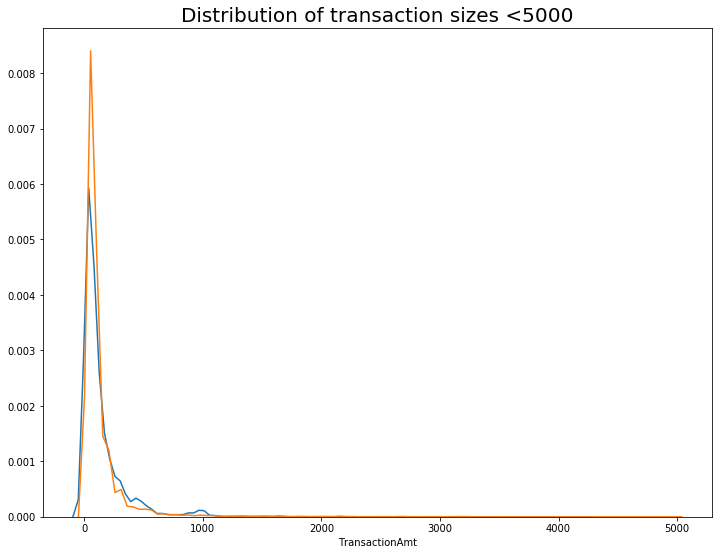

In [6]:
plt.figure(figsize=(12, 9))
ax = sns.distplot(frauds[frauds['TransactionAmt'] < 5000]['TransactionAmt'], hist=False)
ax = sns.distplot(normal[normal['TransactionAmt'] < 5000]['TransactionAmt'], hist=False, ax=ax)
#ax.set_xscale('log')
plt.title('Distribution of transaction sizes <5000', size=20)
plt.show()

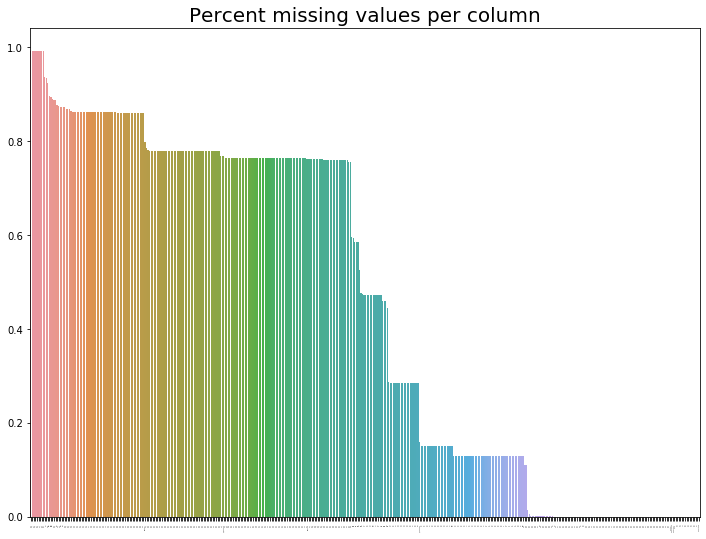

In [7]:
plt.figure(figsize=(12, 9))
sns.barplot(y=df.isnull().sum().sort_values(ascending=False)/len(df), x=df.isnull().sum().sort_values(ascending=False).index)
plt.title('Percent missing values per column', size=20)
plt.xticks(rotation=90, size=1)
plt.show()

# Data Preparation

### Handle missing values

In [8]:
coldf = pd.DataFrame({ 'nan_count': df.isnull().sum().sort_values(ascending=False) })
coldf['percent_nan'] = coldf['nan_count'] / len(df)

limit = 0.15 # A max of 15% may be NaN for any column.
columns_final = list(coldf[coldf['percent_nan'] < limit].index)
df = df[columns_final]

In [9]:
print('Number of columns selected: ' + str(df.shape[1]))

Number of columns selected: 160


### Handle non-float entries

In [10]:
df[df.select_dtypes(include=['object']).columns][0:10]

,card4,card6,ProductCD
0,discover,credit,W
1,mastercard,credit,W
2,visa,debit,W
3,mastercard,debit,W
4,mastercard,credit,H
5,visa,debit,W
6,visa,debit,W
7,visa,debit,W
8,visa,debit,H
9,mastercard,debit,W


In [11]:
# We will assume that the brands of the cards used are not as important as their type.
# Thus, we only one-hot-encode column 'card6'
card6df = pd.get_dummies(df['card6'])

df = pd.concat([df, card6df], axis=1)
df = df._get_numeric_data().dropna() # This drops other non-numerical columns and drops NaN values, too.

### Split dataset and normalize

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

In [14]:
def normalize(X):
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std() if X[feature].std() != 0.0 else 1.0
    return X

In [15]:
X_train = normalize(X_train)
X_test = normalize(X_test)

f:\pythonenvironments\machinelearning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
f:\pythonenvironments\machinelearning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Modeling

In [17]:
from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import recall_score

In [18]:
regressor = LogisticRegression(max_iter=10000, solver='lbfgs')  
regressor.fit(X_train, y_train)

print('Testing accuracy of the logistic regression model: {:1.4f}'.format(regressor.score(X_test, y_test)))

Testing accuracy of the logistic regression model: 0.9795


In [19]:
y_pred = regressor.predict(X_test)

In [20]:
pd.crosstab(y_test, y_pred, rownames=['True Label'], colnames=['Predicted Label'], margins=True)

Predicted Label,0,1,All
True Label,,,
0,171237,150,171387
1,3443,105,3548
All,174680,255,174935


In [21]:
print('The recall score of the model is {:1.4f}'.format(recall_score(y_test, y_pred)))

The recall score of the model is 0.0296


### This is not the way!
To fix:
- Class imbalance
- Large number of columns are dropped due to NaN
- One-hot-encode more categorical columns
- Use a clustering algorithm instead